In [30]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import optuna
from optuna.trial import TrialState

In [31]:
device = "cuda"
Epochs = 10
classes = 10

In [32]:
t = transforms.Compose([transforms.ToTensor(),
                       transforms.Lambda(lambda x : x.permute(1, 2, 0).reshape(-1))
                       ])
target_t = lambda label: F.one_hot(torch.tensor(label), num_classes=10)


train_dataset = datasets.SVHN(root="./data", split="train", transform= t, target_transform=target_t, download=True)
test_dataset = datasets.SVHN(root="./data", split="test", transform= t, target_transform=target_t, download=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [33]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


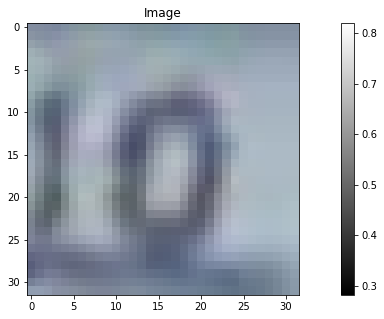

In [34]:
# print(next(iter(test_loader)))
img = next(iter(test_loader))[0][3].reshape(32,32,3)
label = next(iter(test_loader))[1][3]
def visual(img):    
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)

    img = img.numpy()
    im = ax.imshow(img, cmap=plt.cm.gray)
    fig.colorbar(im)
    ax.set_title("Image")

visual(img)
print(label)

In [35]:
#defining the model 

def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 4)
    
    layers = []
    
    in_features = 3 * 32 * 32
    for i in range(n_layers):
        out_features = trial.suggest_int(f"n_units_layer{i}", 256, 1024)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLu())
        
        in_features = out_features
    layers.append(nn.Linear(in_features, classes))
    layers.append(nn.LogSoftmax(dim=1))
    
    return nn.Sequential(*layers)

In [36]:
def objective(trial):
    
    model = Network().to(device)
    
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)
    
    #training
    for epoch in range(Epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.type(torch.float32).to(device)
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
        #validation
        model.eval()
        total_corr = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                
                data, target = data.to(device), target.type(torch.float32).to(device)
                output = model(data)
                pred = torch.argmax(output, dim=1)
                
                gt = torch.argmax(target, dim=1)
                correct = torch.count_nonzero(pred == gt)
                total_corr += correct
        accuracy = (total_corr/len(test_dataset))
        
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [37]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-11-13 13:46:06,633] A new study created in memory with name: no-name-c9168556-5e8d-404f-b3fc-d96e9698e636
[I 2021-11-13 13:48:10,459] Trial 0 finished with value: 0.3597879409790039 and parameters: {'optimizer': 'RMSprop', 'lr': 1.3407260134306161e-05}. Best is trial 0 with value: 0.3597879409790039.
[I 2021-11-13 13:50:13,414] Trial 1 finished with value: 0.19587430357933044 and parameters: {'optimizer': 'Adam', 'lr': 0.03471767730956415}. Best is trial 0 with value: 0.3597879409790039.
[I 2021-11-13 13:52:15,564] Trial 2 finished with value: 0.6826981902122498 and parameters: {'optimizer': 'Adam', 'lr': 0.0022885488896675493}. Best is trial 2 with value: 0.6826981902122498.
[I 2021-11-13 13:54:16,676] Trial 3 finished with value: 0.19587430357933044 and parameters: {'optimizer': 'SGD', 'lr': 0.00020908177501087637}. Best is trial 2 with value: 0.6826981902122498.
[I 2021-11-13 13:56:19,114] Trial 4 finished with value: 0.6528118848800659 and parameters: {'optimizer': 'Adam', 

[I 2021-11-13 14:53:57,938] Trial 80 pruned. 
[I 2021-11-13 14:54:36,046] Trial 81 pruned. 
[I 2021-11-13 14:54:48,926] Trial 82 pruned. 
[I 2021-11-13 14:55:01,233] Trial 83 pruned. 
[I 2021-11-13 14:55:13,643] Trial 84 pruned. 
[I 2021-11-13 14:55:25,824] Trial 85 pruned. 
[I 2021-11-13 14:55:38,649] Trial 86 pruned. 
[I 2021-11-13 14:55:50,799] Trial 87 pruned. 
[I 2021-11-13 14:56:29,161] Trial 88 pruned. 
[I 2021-11-13 14:57:20,885] Trial 89 pruned. 
[I 2021-11-13 14:57:34,200] Trial 90 pruned. 
[I 2021-11-13 14:59:51,590] Trial 91 finished with value: 0.7017516493797302 and parameters: {'optimizer': 'Adam', 'lr': 0.0019046538818773666}. Best is trial 40 with value: 0.7118930220603943.
[I 2021-11-13 15:00:04,393] Trial 92 pruned. 
[I 2021-11-13 15:00:29,388] Trial 93 pruned. 
[I 2021-11-13 15:00:42,646] Trial 94 pruned. 
[I 2021-11-13 15:00:55,186] Trial 95 pruned. 
[I 2021-11-13 15:01:20,480] Trial 96 pruned. 
[I 2021-11-13 15:01:33,103] Trial 97 pruned. 
[I 2021-11-13 15:01:45,5

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  76
  Number of complete trials:  24
Best trial:
  Value:  0.7118930220603943
  Params: 
    optimizer: Adam
    lr: 0.001216659090796907


In [15]:
# class Network(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.input_dims = 3072
#         self.layer1 = nn.Linear(in_features=3072, out_features=512)
#         self.layer2 = nn.Linear(in_features=512, out_features=256)
#         self.layer3 = nn.Linear(in_features=256, out_features=64)
#         self.layer4 = nn.Linear(in_features=64, out_features=10)
        
#         self.relu1 = nn.ReLU(inplace=True)
#         self.relu2 = nn.ReLU(inplace=True)
#         self.relu3 = nn.ReLU(inplace=True)
    
#     def forward(self, x):
#         x = self.relu1(self.layer1(x))
#         x = self.relu2(self.layer2(x))
#         x = self.relu3(self.layer3(x))
#         x = self.layer4(x)
#         pred = F.log_softmax(x, dim=1)
#         return x

# model = Network()
# model.to(device)
# criterion = nn.CrossEntropyLoss().to(device)

# lr = 1e-3
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# def training(Epochs=20):
#     loss_list= []
#     loss_hist  = []
#     for epoch in range(Epochs):
#         cur_loss_list = []
#         progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
#         for i, (img, label) in progress_bar:
#             img, label = img.to(device), label.type(torch.float32).to(device)

#             pred = model.forward(img)

#             loss = criterion(pred, label)
#             cur_loss_list.append(loss.item())
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             if(i % 1 == 0):
#                 progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
#         loss_list = loss_list + cur_loss_list        
#         loss_hist.append(np.mean(cur_loss_list))
#     return loss_list, loss_hist
# training()

# def testing(test_loader, net):
#     with torch.no_grad():
#         total_corr = 0
#         for x, y in test_loader:
# #             x, y = x.to(device), y.type(torch.float32).to(device)

#             output = net.forward(x)

#             pred = torch.argmax(torch.Tensor(output), dim=1)
#             gt = torch.argmax(y, dim=1)
#             correct = torch.count_nonzero(pred == gt)
#             total_corr += correct
#         return (total_corr/len(test_dataset))

# testing(test_loader, model.to("cpu"))